# Explanation methods

Deep learning models are becoming better and better at making predictions.
As researchers, regulators, and users, we are also interested in asking additional questions.
Namely, we would like to _explain_ a decision in terms of the input.
Where in an image is a model focusing on?
What cues is the prediction based on? Ddoes it match our expectation?
Can the model be trusted?

In this practical, we will explore popular methods for explaining decisions made by image classifiers:
- Simple occlusion
- Gradient norm
- Gradient x input
- GradCAM
- Integrated gradients

With a working implementation of each method, we will compare explanations qualitatively on a few sample images.

Furthermore, we will evaluate the correctness of each method quantitatively using the _deletion score_.

## Setup

In [1]:
!pip install "jax[cuda]" -f 'https://storage.googleapis.com/jax-releases/jax_cuda_releases.html'

!pip install \
  flax optax \
  'git+https://github.com/n2cholas/jax-resnet.git' \
  tensorflow-datasets \
  better_exceptions

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Cloning https://github.com/n2cholas/jax-resnet.git to /tmp/pip-req-build-y5xyj0k6
  Running command git clone --filter=blob:none --quiet https://github.com/n2cholas/jax-resnet.git /tmp/pip-req-build-y5xyj0k6
  Resolved https://github.com/n2cholas/jax-resnet.git to commit 5b00735aa0a68ec239af4a728ad4a596c1b551f6
  Preparing metadata (setup.py) ... done
  Created wheel for jax-resnet: filename=jax_resnet-0.0.4-py2.py3-none-any.whl size=11893 sha256=12273f53b9ccbcd16a89bfb107732a50c58f14f1b1a6cf3273db7d11366bfa8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-h2mooepb/wheels/e5/9f/12/68e7acc9319a25f1006d5ac41

In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf

tf.get_logger().setLevel("WARNING")
tf.config.experimental.set_visible_devices([], "GPU")

from collections import defaultdict
from functools import partial
from typing import Sequence

import flax.core
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax_resnet
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import sklearn.metrics
import tabulate
import tensorflow_datasets as tfds
import torch
import tqdm
from flax.training.train_state import TrainState
from IPython.display import display
from jax import jit, vmap

RED = np.array([1.0, 0, 0])
BLUE = np.array([0, 0, 1.0])


@jax.jit
def normalize_zero_one(x):
    """Normalize a vector between 0 and 1."""
    res = (x - x.min()) / (x.max() - x.min())
    res = jnp.clip(res, a_min=0, a_max=1)
    return res


@jax.jit
def normalize_max(x):
    """Normalize a vector between -1 and 1."""
    res = x / jnp.abs(x).max()
    res = jnp.clip(res, a_min=-1, a_max=1)
    return res


@jax.jit
def blend(a, b, alpha: float):
    """Blend two float-valued images"""
    return (1 - alpha) * a + alpha * b

## Dataset

For simplicity, we will use the small ImageNette dataset that contains 10 easy-to-classify categories from ImageNet.

Here we load the dataset and show a few images that will be used throughout this notebook.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling imagenette/320px-v2/incomplete.A6C7T1_1.0.0/imagenette-train.tfrecord*...:   0%|          | 0/9469 […

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling imagenette/320px-v2/incomplete.A6C7T1_1.0.0/imagenette-validation.tfrecord*...:   0%|          | 0/3…

Dataset imagenette downloaded and prepared to imagenette/320px-v2/1.0.0. Subsequent calls will reuse this data.


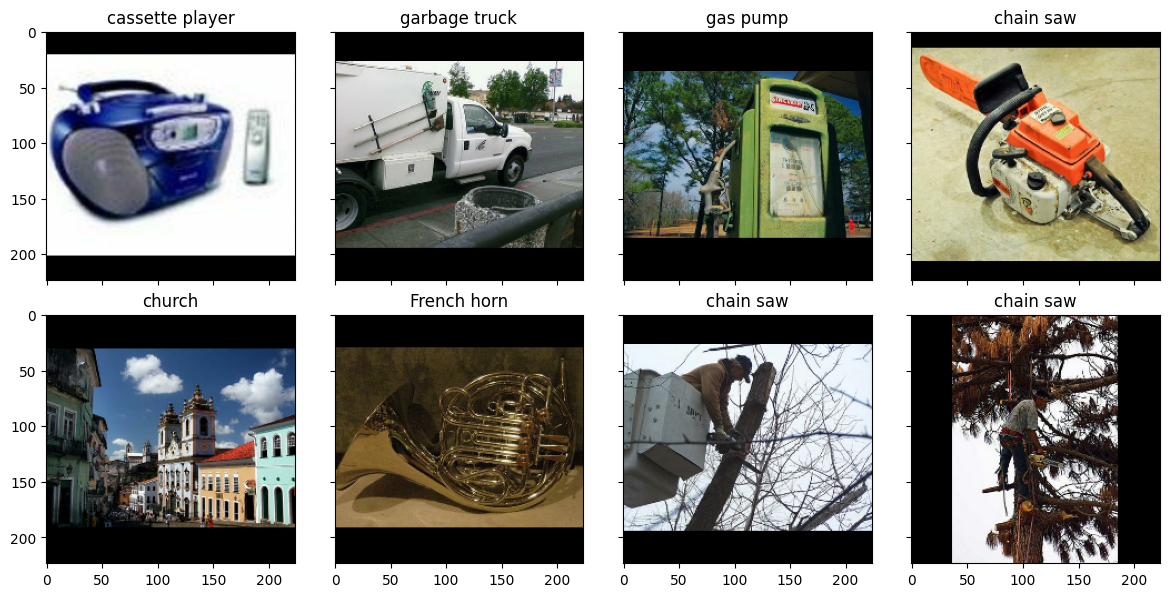

In [3]:
CLASS_NAMES = [
    "tench",
    "English springer",
    "cassette player",
    "chain saw",
    "church",
    "French horn",
    "garbage truck",
    "gas pump",
    "golf ball",
    "parachute",
]


def show_images(images, labels=None, logits=None, ncols=4, width_one_img_inch=3.0):
    B, H, W, *_ = images.shape
    nrows = int(np.ceil(B / ncols))
    fig, axs = plt.subplots(
        nrows,
        ncols,
        figsize=width_one_img_inch * np.array([1, H / W]) * np.array([ncols, nrows]),
        sharex=True,
        sharey=True,
        squeeze=False,
        facecolor="white",
    )
    for b in range(B):
        ax = axs.flat[b]
        ax.imshow(images[b])
        if labels is not None:
            ax.set_title(CLASS_NAMES[labels[b]])
        if logits is not None:
            pred = logits[b].argmax()
            prob = nn.softmax(logits[b])[pred]
            color = (
                "blue" if labels is None else ("green" if labels[b] == pred else "red")
            )
            p = mpl.patches.Patch(color=color, label=f"{prob:.2%} {CLASS_NAMES[pred]}")
            ax.legend(handles=[p])
    fig.tight_layout()
    display(fig)
    plt.close(fig)


def resize(image, label):
    image = tf.image.resize_with_pad(image, 224, 224)
    return image / 255.0, label


ds_builder = tfds.builder("imagenette/320px-v2", data_dir=".")
ds_builder.download_and_prepare()

ds = ds_builder.as_dataset(split="train", batch_size=None, as_supervised=True)
ds = ds.map(resize)
ds = ds.batch(8)
ds = tfds.as_numpy(ds)
viz_batch = next(iter(ds))

images, labels = viz_batch
show_images(images, labels)

## Pretrained ResNet

We will focus on a ResNet 18 model for the explanations which has been ported from PyTorch thanks to [this repo](https://github.com/n2cholas/jax-resnet).

The simplest way to load and run a ResNet model using `jax_resnet` is:
```python
ResNet, variables = jax_resnet.pretrained_resnet(size)
model = ResNet()
img = jnp.zeros(224, 224, 3)                        # [H, W, C]
logits = model.apply(variables, img[None, ...])[0]  # [1000]
```

### Task 1

Here we load a pre-trained model and prepare it for our purposes.
We want the following:
1. The function should operate on a single image instead of a batch.
   Altough counterintuitive, this will make it easier to reason about explanations later
   and is more in tune with the philosophy of jax.
2. The function should take care of normalizing the image with mean `[0.485, 0.456, 0.406]`
   and std `[0.229, 0.224, 0.225]` as done for the PyTorch models that this model was converted from.
   Refer to [torchvision.transforms.Normalize](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize)
   for an example.
3. Select out of the 1000 ImageNet classes the 10 ImageNette classes that we are interested in.
4. The function should return the largest element of the 10-dimensional logits vector,
   since later on we'll often compute gradients of it. The full logits  vector should
   also be returned for prediction and visualization purposes.

Complete the function `logits_fn` returned by `load_resnet` so that it fullfills the requirements above.
Upon executing the cell you should see 7/8 correct predictions with almost-certain confidence.

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


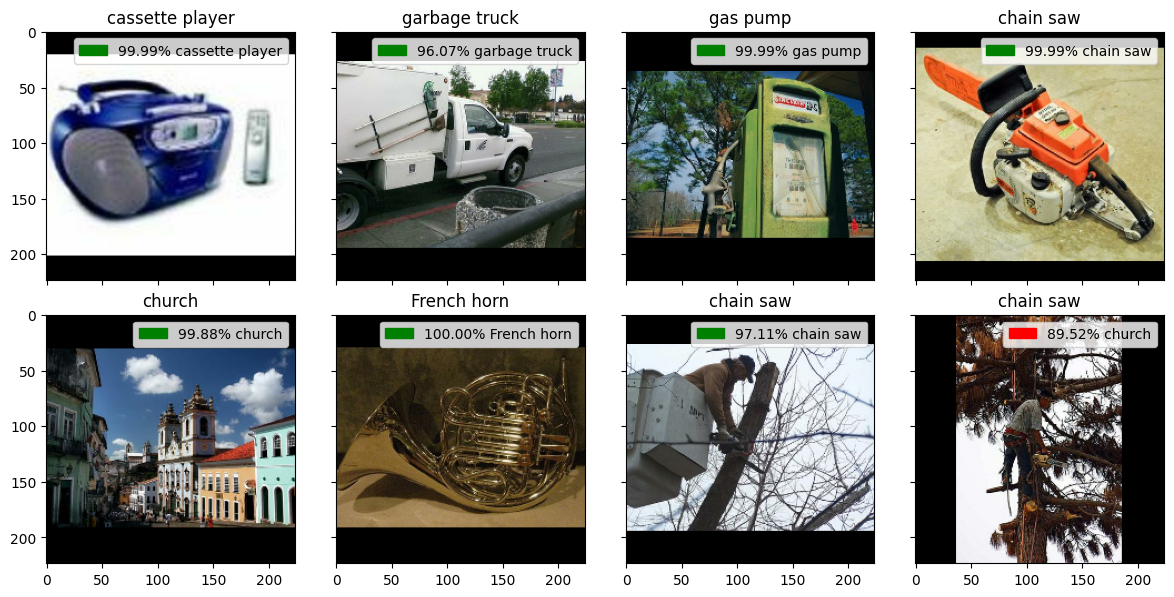

In [7]:
def load_resnet(size):
    """Load a resnet model and return resnet_logits_fn and its variables.

    Returns:
        logits_fn: a jitted function that given one image applies
                   the resnet model and returns the max logit
                   value and the logits vector
        variables: resnet variables to use with logits_fn
    """

    def logits_fn(variables, img):
        # img: [H, W, C], float32 in range [0, 1]
        assert img.ndim == 3

        # TODO
        normalized_img = normalize_for_resnet(img)
        logits = model.apply(variables, normalized_img[None, ...])[0]
        logits = imagenet_to_imagenette_logits(logits)

        # logits: [num_classes]
        return logits.max(), logits


    ResNet, variables = jax_resnet.pretrained_resnet(size)
    model = ResNet()
    logits_fn = jax.jit(logits_fn)
    return logits_fn, variables


def normalize_for_resnet(image):
    mean = jnp.array([0.485, 0.456, 0.406])
    std = jnp.array([0.229, 0.224, 0.225])
    return (image - mean) / std


def imagenet_to_imagenette_logits(logits):
    """Select the 10 imagenette classes from the 1000 imagenet classes."""
    return logits[..., [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]]


logits_fn, variables = load_resnet(size=18)
images, labels = viz_batch
_, logits = jax.vmap(logits_fn, (None, 0))(variables, images)
assert logits.shape == (images.shape[0], len(CLASS_NAMES))
show_images(images, labels, logits)

## Explanation methods

### Occlusion

The simplest explanation method consists in removing patches of the input image and measuring the effect on prediction confidence.
Specifically, we want to measure the drop (or increase) in confidence in the predicted class between the original non-occluded image and an occluded version.

We will use a single square patch of fixed size that is scanned over the entire image without overlap, altough it would be possible to
come up with more advanced patterns of occlusion.

#### Task 2

Complete the function `prepare_occlusions` that takes in a single image of shape `[H, W, 3]`
and outputs a batch of images of shape `[S, S, H, W, 3]` where the image at `[i, j]` contains
a black patch of size `[H/S, W/S]` whose top-left corner is placed at `[i*H/S, j*W/S]`.

Explained with a drawing:
```
imgs[i, j] =
                j*W/S
      ┌───────────┬────┬────┐
      │           |    |    │
      │           |    |    │
i*H/S ├ ─ ─ ─ ─ ─ ┼────┤    │
      │           │####│    │
      │           │####│    │
      ├ ─ ─ ─ ─ ─ ┴────┘    │
      │                     │
      │                     │
      │                     │
      │                     │
      │                     │
      └─────────────────────┘
```

Remember that in jax arrays can not be modified in-place.
Use [`at[].set()`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html) instead:
```python
x[idx] = y  # Bad
x = x.at[idx].set(y)  # Good
```

Once the missing lines in `prepare_occlusions` are filled in, visualize the resulting batch of partially-occluded images to check your implementation.

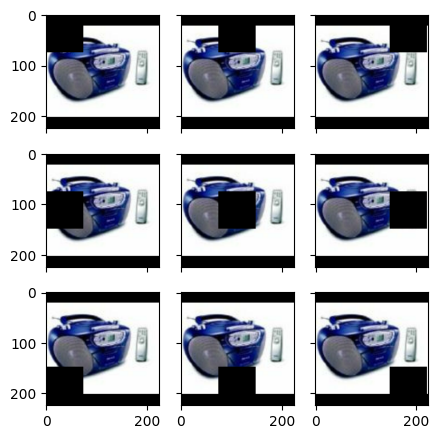

In [10]:
def prepare_occlusions(img, steps: int):
    H, W, _ = img.shape
    imgs = jnp.tile(img, (steps, steps, 1, 1, 1))

    # TODO
    hight_step = H // steps
    width_step = W // steps
    for i in range(steps):
        for j in range(steps):
            imgs = imgs.at[i, j, i * hight_step  : (i + 1) * hight_step, j * width_step : (j + 1) * width_step].set(0)

    # imgs: [steps, steps, H, W, 3]
    return imgs


prepare_occlusions = jax.jit(prepare_occlusions, static_argnames="steps")

show_images(
    prepare_occlusions(viz_batch[0][0], steps=3).reshape(-1, 224, 224, 3),
    ncols=3,
    width_one_img_inch=1.5,
)

#### Task 3

Using `prepare_occlusions` implemented above, complete the missing lines in `occlusion_fn` following to this pseudo-code:
```python
probs = f(img)
idx = argmax(probs)
imgs = prepare_occlusions(img)
relevance[i, j] = f(img)[idx] - f(imgs[i, j])[idx]
relevance = resize(relevance, img.shape)
```

With a working implementation, the code below will show positive and negative attributions for eight images.
Positive attribution is shown as a red overlay, while negative attribution is shown in blue (almost invisible except for the last image).

Note: `jit` and `vmap` take care of speeding up and vectorizing `occlusion_fn`
so that it works on a batch of images.
You will see them used as wrappers or decorators throughout the notebook.

Tips:
- you want to compute how much the probability of the original prediction drops, apply `softmax` to the output of `logits_fn` to get probabilities and select the right class with `idx`
- apply vmap twice to `logits_fn` to vectorize it over the two extra axes added by `prepare_occlusions`, you don't need two nested for loops
- use [`jax.image.resize`](https://jax.readthedocs.io/en/latest/_autosummary/jax.image.resize.html#jax.image.resize) with `method="bilinear"` to resize the heatmap to the original size
- use `normalize_max` to rescale the attributions to a range that works well with the visualization code

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


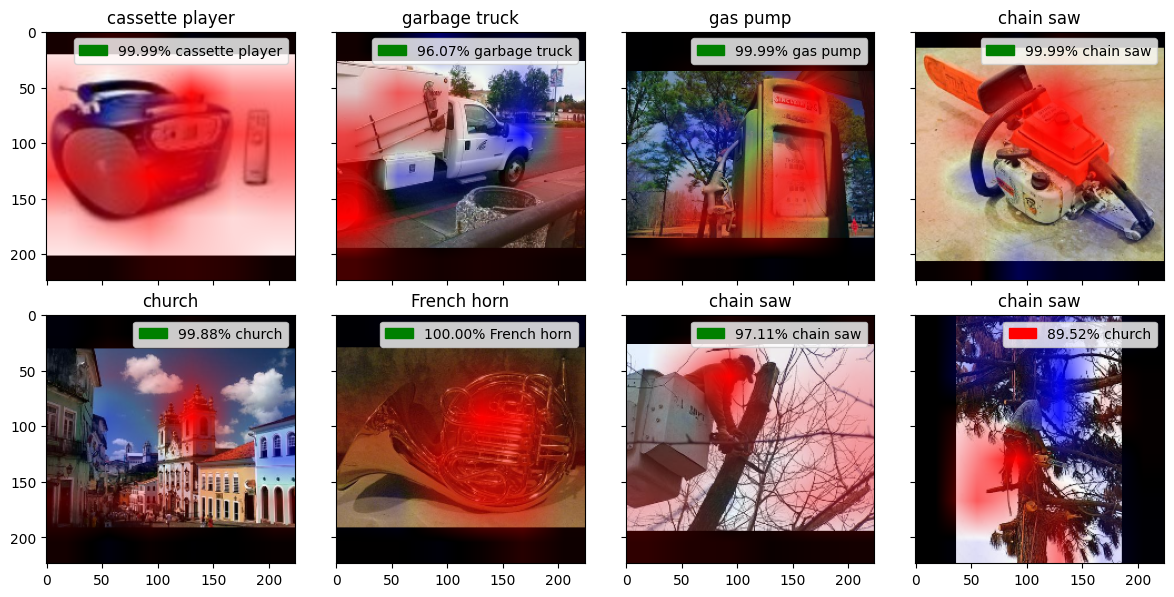

In [18]:
def occlusion_fn(logits_fn, variables, img, steps: int):
    H, W, _ = img.shape

    # TODO
    """probs = f(img)
      idx = argmax(probs)
      imgs = prepare_occlusions(img)
      relevance[i, j] = f(img)[idx] - f(imgs[i, j])[idx]
      relevance = resize(relevance, img.shape)"""
    _, logits_orig = logits_fn(variables, img)
    probs = nn.softmax(logits_orig)
    idx = probs.argmax()

    imgs = prepare_occlusions(img, steps)

    _, logits_occluded = jax.vmap(jax.vmap(logits_fn, in_axes=(None, 0)), in_axes=(None, 0))(variables, imgs)

    relevance = logits_orig[idx] - logits_occluded[:, :, idx]

    attrib = jax.image.resize(relevance, img.shape[:2], method="bilinear")
    attrib = normalize_max(attrib)

    # logits_orig: [num_classes]
    # attrib:      [H, W]
    return logits_orig, attrib


occlusion_fn = jax.jit(occlusion_fn, static_argnames=["logits_fn", "steps"])
occlusion_fn = jax.vmap(occlusion_fn, in_axes=(None, None, 0, None))

images, labels = viz_batch
logits_fn, variables = load_resnet(size=18)
logits, relevance = occlusion_fn(logits_fn, variables, images, 6)

images = blend(images, RED, jnp.clip(relevance, a_min=0)[..., None])
images = blend(images, BLUE, -jnp.clip(relevance, a_max=0)[..., None])
show_images(images, labels, logits)

### Grad norm (sensitivity)

An important tool for decision explanation is the gradient of the prediction function with respect to the input variable evaluated at the input image.
Intuitively, the gradient expresses how much a change in the input would affect the prediction (actually the pre-softmax confidence).
By evaluating the gradient at the input image, we can estimate the relevance $R_i$ of each pixel $i$.

$$
\begin{align}
X &\in \mathbb{R}^{D} \\
p &= f(X) \\
R_i &= \nabla f(X_i)
\end{align}
$$

Since our models operate on images, the gradient w.r.t. an image will have shape `[H, W, 3]`.
For ease of visualization, we will compute the norm of the gradient at each pixel location and visualize it as a heatmap of shape `[H, W]`.

#### Task 4

Complete the missing lines of `grad_norm_fn` so that given a single input image it returns the associated logits and the pixel-wise norm of the gradient of the most confident prediction.

Also, since we want to overlay the explanation to the image, make sure to scale the results in the range `[0, 1]`.

Tips:
- The function `logits_fn` prepared in task 1 returns the maximum logit as its first return value.
- In jax one can use [`jax.value_and_grad`](https://jax.readthedocs.io/en/latest/jax.html#jax.value_and_grad)
  to decorate a function so that both the value and its gradient are returned.
- The function `jax.value_and_grad` can also take an extra parameter `has_aux`
  to indicate that the original function returns more than one value and that those extra values should be returned by the decorated function too. Example:
  ```python
  def foo(a, x):
      y = jnp.exp(x**2) - jnp.sin(a @ x)
      return y.sum(), y
  
  foo_vg = jax.value_and_grad(foo, argnums=1, has_aux=True)
  (y_sum, y), grad_x = foo_vg(a, x)
  ```
- use `normalize_max` to rescale the attributions to a range that works well with the visualization code

In [ ]:
def grad_norm_fn(logits_fn, variables, img):
    H, W, _ = img.shape

    # TODO

    # logits: [num_classes]
    # grad:   [H, W]
    return logits, grad


grad_norm_fn = jax.jit(grad_norm_fn, static_argnames=["logits_fn"])
grad_norm_fn = jax.vmap(grad_norm_fn, in_axes=(None, None, 0))

images, labels = viz_batch
logits_fn, variables = load_resnet(size=18)
logits, relevance = grad_norm_fn(logits_fn, variables, images)

show_images(
    # images * relevance[..., None],
    blend(images, RED, relevance[..., None]),
    labels,
    logits,
)

### Grad x input

To increase the sharpness of the explanations it's possible to multiply the value of the gradient with the corresponding input.
Intuitively, the gradient expresses the importance of a certain feature and is now rescaled by how much that feature is present.

$$R_i = X_i \cdot \nabla f(X_i)$$

#### Task 5

Modify `grad_norm_fn` so that the gradient is multiplied with the image before computing the norm.

In [ ]:
def grad_x_input_fn(logits_fn, variables, img):
    H, W, _ = img.shape

    # TODO

    # logits: [num_classes]
    # grad:   [H, W]
    return logits, grad


grad_x_input_fn = jax.vmap(grad_x_input_fn, in_axes=(None, None, 0))
grad_x_input_fn = jax.jit(grad_x_input_fn, static_argnames=["logits_fn"])

images, labels = viz_batch
logits_fn, variables = load_resnet(size=18)
logits, relevance = grad_x_input_fn(logits_fn, variables, images)

show_images(
    # images * relevance[..., None],
    blend(images, RED, relevance[..., None]),
    labels,
    logits,
)

### Integrated gradients

As observed, gradient-based explanations appear very noisy. This is because gradients can only describe what happens in the local neighborhood of the input image when a pixel is changed by a small quantity, therefore:
- some pixels might be very important for the prediction (e.g. the color of a flower), but the local gradient might be saturated (e.g. different shades of yellow will all give the same confidence in "sunflower") and therefore those pixels will not be marked as relevant.
- a small step in the direction of the gradient might increase the prediction confidence, but a slightly larger step might decrease it further and an even slighly larger step might increase it again.

The integrated gradients method proposes to address this issue by aggregating gradients along a linear path between the input image and a baseline (usually black). By considering a path, the noise associated to local gradients is reduced. Also, using a baseline image allows to express the explanation in relative terms rather than absolute.

By expressing the path as $\gamma(\alpha) = B + \alpha(X-B)$, the method can be expressed as:
$$
R_i = \int_0^1 \frac{\partial f(\gamma(\alpha))}{\partial\gamma_i(\alpha)} \frac{\partial\gamma_i(\alpha)}{\partial\alpha} \ d\alpha.
$$

Which can be approximated as:
$$
R_i \approx (X_i - B_i) \frac{1}{M} \sum_{m=1}^M \frac{\partial f\left(B + m/M(X-B)\right)}{\partial X_i}.
$$

Where $B$ indicates the black baseline, $M$ is the number of steps for approximating the path integral.

The function below computes all intermediate images between an input `img` and a black baseline.

In [ ]:
@partial(jax.jit, static_argnames=["steps"])
def prepare_integrated_gradients(img, steps: int):
    assert img.ndim == 3
    return img[None, :, :, :] * jnp.linspace(1, 0, num=steps)[:, None, None, None]


image = viz_batch[0][0]
images = prepare_integrated_gradients(image, steps=8).reshape(-1, 224, 224, 3)
show_images(images, width_one_img_inch=2)

#### Task 6

Complete the function `integrated_grad_fn` so that:
- a single image is taken as input
- a prediction is made on the input image to determine the predicted class
- a batch of progressively darker images is prepared with `prepare_integrated_gradients`
- for each image in the batch, the gradients of the logit at `idx` is computed
- the path integral is approximated using a finite sum

According to the official implementation, only positive attributions are considered and attributions are averaged per pixel.

Tips:
- Store the index of the most-confident prediction for the input image as `idx` because we need to refer to it when computing gradients
- At each intermediate step you don't want the gradient `max_logit`, i.e.
  the first output of `logits_fn`, which you would get from `grad(logits_fn)`.
  Instead you want the gradient of the `idx`-th element of `logits`, i.e.
  the second output. Define a local function or a lambda and call `grad` on that.
- You don't need for loops, use `vmap`

In [ ]:
def integrated_grad_fn(logits_fn, variables, img, steps: int):
    H, W, _ = img.shape

    # TODO

    # logits: [num_classes]
    # grads:  [H, W]
    return logits, grads


integrated_grad_fn = jax.jit(integrated_grad_fn, static_argnames=["logits_fn", "steps"])
integrated_grad_fn = jax.vmap(integrated_grad_fn, in_axes=(None, None, 0, None))

images, labels = viz_batch
logits_fn, variables = load_resnet(size=18)
logits, relevance = integrated_grad_fn(logits_fn, variables, images, 25)

show_images(
    # images * relevance[..., None],
    blend(images, RED, relevance[..., None]),
    labels,
    logits,
)

### GradCAM

GradCAM decomposes the ResNet model in two blocks: a CNN backbone and a linear classifier, separated by global average pooling.
$$
\begin{align}
X &\in \mathbb{R}^{H\times W\times 3} \\
A &= \text{Backbone}(X) \in \mathbb{R}^{H'\times W'\times K}\\
Y &= \text{Linear}(\text{GAP}(A)) \in \mathbb{R}^C
\end{align}
$$

The main idea is to consider the gradient of the activations before global average pooling and use them to rescale the intensity of the associated feature maps.
Specifically, if the predicted class is $c$, the scaling factor for the $k$-th feature map is:
$$
\alpha_c^k = \frac{1}{H'W'} \sum_i^{H'}\sum_j^{W'} \frac{\partial Y^c}{\partial A^k_{i,j}}
$$

The feature maps are then combined into a sized-down attribution as:
$$
R_c = \text{ReLU}\left( \sum_k^K \alpha_c^k A^k\right) \in \mathbb{R}^{H'\times W'}
$$

Finally, the relevance heatmap is resized to match the input image. Compared to the gradient-based methods above, GradCAM produces much smoother heatmaps thanks to this upsampling operation.

#### Task 7

Implement the missing parts of `grad_cam_fn`:
- First, process the image through the backbone
- Then, process the features through global average pooling the through the classifier.
  Remember that you'll need the gradients w.r.t. these features.
- Once you have the gradients, combine them with the features as indicated above and
  resize the relevance to the same size of the input image.
- As usual, return both the logits vector and the relevance matrix.

Tips:
- You will need to apply the backbone and the classifier separately.
  The function `load_resnet_for_grad_cam` takes care of splitting the model and its variables for you.<br/>
  They are returned as two dictionaries, both containing the keys `backbone` and `gap_cls`.
- When performing complex sums and products [`jnp.einsum`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.einsum.html)
  can drastically simplify the amount of error-prone reshaping code required.

In [ ]:
def grad_cam_fn(fns, variables, img):
    H, W, _ = img.shape

    # TODO

    # logits: [num_classes]
    # grad:   [H, W]
    return logits, grad


def load_resnet_for_grad_cam(size):
    @jax.jit
    def backbone_fn(variables, img):
        # img:   [H, W, C], float32 in range [0, 1]
        # feats: [h, w, c], float32
        img = normalize_for_resnet(img)
        feats = backbone.apply(variables, img[None, ...], mutable=False)[0]
        return feats

    @jax.jit
    def gap_classifier_fn(variables, feats):
        # feats:  [h, w, c], float32
        # logit:  float32
        # logits: [10], float32
        logits = gap_classifier.apply(variables, feats[None, ...], mutable=False)[0]
        logits = imagenet_to_imagenette_logits(logits)
        return logits.max(), logits

    ResNet, variables = jax_resnet.pretrained_resnet(size)
    model = ResNet()

    backbone = nn.Sequential(model.layers[:-2])
    backbone_vars = jax_resnet.slice_variables(variables, start=0, end=-2)
    gap_classifier = nn.Sequential(model.layers[-2:])
    gap_classifier_vars = jax_resnet.slice_variables(variables, start=len(model.layers) - 2, end=None)
    return (
        flax.core.freeze({"backbone": backbone_fn, "gap_cls": gap_classifier_fn}),
        flax.core.freeze({"backbone": backbone_vars, "gap_cls": gap_classifier_vars}),
    )


grad_cam_fn = jax.jit(grad_cam_fn, static_argnames=["fns"])
grad_cam_fn = jax.vmap(grad_cam_fn, in_axes=(None, None, 0))

images, labels = viz_batch
fns, variables = load_resnet_for_grad_cam(size=18)
logits, relevance = grad_cam_fn(fns, variables, images)

show_images(
    images * relevance[..., None],
    labels,
    logits,
)

## Deletion score

So far, we have evaluated the explanations qualitatively by drawing them as heatmaps over a few sample images.
A common metric used to evaluate the _correctness_ of an explanation method quantitatively is the _deletion score_.
It is computed by progressively removing pixels from an image in order of importance and measuring the corresponding drop in confidence.
The behavior can be visualized on a plot that has the percentage of removed pixels on the horizontal axis and the prediction confidence on the vertical axis.

Ideally, if the most-relevant pixels are actually important for the prediction, their removal should induce a sudden drop in confidence for that label.
To summarize this idea with a number we can compute the area under the curve: a low area indicates a quick decline in confidence, hence a good explanation method. This value is denoted as _deletion score_.

### Single-image deletion score

#### Task 8

Implement a function `prepare_deletion` that given an image and the associated relevance prepares a batch of `steps` images.
If we indicate the resulting batch as `imgs`, not that:
- `imgs[0]` corresponds to the input image
- `imgs[s]` is a copy of the input image with `s/(steps-1)` percent of black pixels
- `imgs[-1]` is an all-black image
- pixels are set to zero in order of relevance with the most-relevant ones first
- if a pixel `(i, j)` is set to black at step `s` it will remain black in all subsequent steps, i.e. the images become progressively more black

The code below samples a random relevance mask and shows the images resulting from `prepare_deletion` so that you can verify the implementation.
Check that the first regions to become black are the ones with the highest relevance.

Tips:
- It's easier to reason about the flattened versions of the image and the relevance matrices, use `jnp.ndarray.flatten` and `jnp.unravel_index` to move back and forth between one and two dimensions
- use `jnp.argsort` and `jnp.array_split` to sort and split the relevance, but be careful about sorting in ascending/descending order

In [ ]:
def prepare_deletion(img, relevance, steps: int):
    assert relevance.shape == img.shape[:2]
    H, W, _ = img.shape
    imgs = jnp.tile(img, (steps, 1, 1, 1))

    # TODO

    # imgs: [steps, H, W, 3]
    return imgs


prepare_deletion = jax.jit(prepare_deletion, static_argnames="steps")

relevance = jax.random.uniform(jax.random.PRNGKey(42), (7, 7))
relevance = jax.image.resize(relevance, (224, 224), method="bilinear")
relevance = normalize_zero_one(relevance)

image = plt.get_cmap('viridis')(relevance)[..., :3]

steps=8
images = prepare_deletion(image, relevance, steps)
assert images.shape == (steps, *image.shape)
show_images(images, width_one_img_inch=2)

#### Task 9

Using the `prepare_deletion` function implemented above, complete the missing lines of `deletion_score_fn`:
- The function takes as input an image, its relevance, and a number of steps
- The function returns a vector of length `steps` containing the probabilities associated to the top-scoring class predicted by the model as more and more relevant pixels are removed
- The function returns the original prediction `pred_orig` too

The cell below contains a few lines of code for plotting the resulting curve and the associated score.
You should see the confidence curve slowly decreasing to zero and eventually rising up slighlty.

Tips:
- The expected value for the area under the curve is `0.270`
- You don't need for loops, use `vmap`

In [ ]:
def deletion_score_fn(logits_fn, variables, img, relevance, steps):
    H, W, _ = img.shape

    # TODO

    # probs: [steps]
    # pred_orig: int
    return probs, pred_orig


deletion_score_fn = jax.jit(deletion_score_fn, static_argnames=["logits_fn", "steps"])

image = viz_batch[0][2]
relevance = jax.random.uniform(jax.random.PRNGKey(42), (7, 7))
relevance = jax.image.resize(relevance, image.shape[:2], method="bilinear")
relevance = normalize_zero_one(relevance)

steps = 8
logits_fn, variables = load_resnet(size=18)
probs, pred = deletion_score_fn(logits_fn, variables, image, relevance, steps)
auc = sklearn.metrics.auc(np.linspace(0,1,steps), probs)
assert len(probs) == steps

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.fill_between(np.linspace(0, 1, steps), probs)
ax.set_ylabel(f"Confidence for '{CLASS_NAMES[pred]}'")
ax.grid(axis="y")
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Pixels removed")
ax.set_title(f"Deletion score: {auc:.3f}");

### Visualize deletion on some images

The following code visualizes the explanations of all methods for the eight images used so far.
On the right the deletion curve and its area is also plotted.

#### Task 10

No implementation required, just take a moment to compare the explanations:
- How do they look side-by-side?
  Does the deletion curve match what you see in the image?
- Which one do you trust the most? Motivate your feeling!
- Does your judgement correlate well with the deletion score?
- Is there a method that is consistently better?

Add your comments below:
- **TODO**

In [ ]:
logits_fn, variables = load_resnet(size=18)
logits_fns_gc, variables_gc = load_resnet_for_grad_cam(size=18)

# Use lambdas instead of partial because vmap doesn't play well with kwargs
all_methods = {
    "occlusion": lambda images: occlusion_fn(logits_fn, variables, images, 6),
    "grad": lambda images: grad_norm_fn(logits_fn, variables, images),
    "grad_x_input": lambda images: grad_x_input_fn(logits_fn, variables, images),
    "grad_cam": lambda images: grad_cam_fn(logits_fns_gc, variables_gc, images),
    "integrated_gradients": lambda images: integrated_grad_fn(logits_fn, variables, images, 20),
}

# These logits are only needed for visualization
images, labels = viz_batch
_, logits = jax.vmap(logits_fn, (None, 0))(variables, images)

In [ ]:
deletion_score_fn_vmap = jax.vmap(deletion_score_fn, in_axes=(None, None, 0, 0, None))

fig, axs = plt.subplots(
    len(images),
    len(all_methods) + 1,
    figsize=((len(all_methods) + 3) * 3, len(images) * 3),
    gridspec_kw={"width_ratios": len(all_methods) * [1] + [3], "wspace": 0.001},
)

# Write true/predicted class on the left side of each row
for ax, lb, lg in zip(axs[:, 0], labels, logits):
    ax.set_ylabel(f"True {CLASS_NAMES[lb]}\nPred {CLASS_NAMES[lg.argmax()]}")

# Column headers: method names + deletion curve
for ax, method in zip(axs[0, :-1], all_methods.keys()):
    ax.set_title(method)
axs[0, -1].set_title("Deletion curve")

# Each explanation method gets its own column on the left and its own curve on the right
for method_col, (method, method_fn) in zip(axs[:, :-1].T, all_methods.items()):
    _, relevance = method_fn(images)
    for ax, img, rel in zip(method_col, images, relevance):
        ax.imshow(blend(img, RED, normalize_zero_one(rel)[..., None]))

    probs, _ = deletion_score_fn_vmap(logits_fn, variables, images, relevance, 25)
    for ax, p in zip(axs[:, -1], probs):
        auc = sklearn.metrics.auc(np.linspace(0, 1, len(p)), p)
        ax.plot(np.linspace(0, 1, len(p)), p, label=f"{auc:.3f} {method}")

# Remove inner ticks for the image grid
for ax in axs[:-1, :-1].flat:
    ax.set_xticks([])
for ax in axs[:, 1:-1].flat:
    ax.set_yticks([])

# Annotate right column on the rightmost edge
for ax in axs[:, -1]:
    axt = ax.twinx()
    axt.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    axt.set_ylabel("Confidence")
    axt.grid()
    ax.set_yticks([])
    ax.legend(loc="upper right", framealpha=1.0)

# Remove pixel percent ticks from right column, except at the bottom
for ax in axs[:-1, -1]:
    ax.set_xticklabels([])
axs[-1, -1].xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
axs[-1, -1].set_xlabel("Pixels removed");

### Average deletion score on entire dataset

To better compare the explanation methods, we can compute the average deletion score across the entire dataset.
This value should give us an indication of which method is best at identifying relevant pixels for a prediction.

#### Task 11

No implementation required, just consider the results of this evaluation:
- Which method seems to be best?
- Can you trust results with such a high standard deviation?
- What can be the cause of it? Think both of how the metric is computed and
  of how the content of an image might affect the score.

Add your comments below:
- **TODO**

Warning: the following code might take a long time to run and/or run out of memory.
For reference, on a single GPU with 10 GB of memory and batch size 32, the total time for all the loops is approximately 10 minutes.
You may need to reduce the batch size or limit the number of images.

In [ ]:
deletion_steps = 10

avg_auc = []
deletion_steps_arr = np.linspace(0, 1, deletion_steps)
logits_fn, variables = load_resnet(size=18)
fns_gc, variables_gc = load_resnet_for_grad_cam(size=18)

ds = ds_builder.as_dataset(split="train", batch_size=None, as_supervised=True)
ds = ds.map(resize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
ds = ds.batch(32, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
# ds = ds.take(50)  # limit number of batches
ds = ds.prefetch(4)
ds = tfds.as_numpy(ds)

for method, method_fn in all_methods.items():
    aucs = []
    for images, labels in tqdm.tqdm(ds, ncols=0, desc=method):
        _, relevance = method_fn(images)
        probs, _ = deletion_score_fn_vmap(logits_fn, variables, images, relevance, deletion_steps)
        aucs.extend(sklearn.metrics.auc(deletion_steps_arr, p) for p in probs)
    avg_auc.append({"method": method, "mean": np.mean(aucs), "std": np.std(aucs)})

avg_auc = pd.DataFrame(avg_auc)
display(avg_auc.set_index("method"))

fig, ax = plt.subplots(1, 1, figsize=(8, 4), facecolor="white")
avg_auc.plot(
    "method",
    "mean",
    yerr="std",
    kind="bar",
    rot=0,
    figsize=(10, 5),
    legend=None,
    ylim=(0, 1),
    xlabel="",
    title="Average deletion score (lower is better)",
    ax=ax
)
display(fig)
plt.close(fig)

## Conclusion

To help us improve this practical:
- How long did it take to complete this notebook?
- What was the most difficult part?